In [1]:
import yaml
import umap

import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor

from cmonge.utils import load_config
from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "orange": "#FE6100",
    "yellow": "#FFB000",
    "grey": "#DDDDDD",
}

ot_map = {
    "source": default_colors["blue"],
    "target": default_colors["pink"],
    "transport": default_colors["yellow"],
    "rest": default_colors["grey"]
}

In [5]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/notebook_logger.json"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood//LN_True_grad_acc_4_cosine/"
base_ckpt_path =   "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood//LN_True_grad_acc_4_cosine/"
base_fig_save =    "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/cmonge/ood/"

In [6]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
        config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)
    
        all_meta[["UMAP1", "UMAP2"]] = Y2
    
        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.xlabel("UMAP1", fontsize=18)
        plt.ylabel("UMAP2", fontsize=18)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.close()
        

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32272/3662288328.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 20:49:22.788 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-23 20:49:23.150 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:49:23.295 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 20:49:23.295 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:49:23.295 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:49:23.296 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:49:29.810 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-23 20:49:40.073 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-23 20:49:40.407 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:49:40.413 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-23 20:49:40.414 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:49:40.414 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:49:40.414 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:49:45.935 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(145, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD40-z


2025-08-23 20:49:52.029 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-23 20:49:52.343 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:49:52.349 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-23 20:49:52.349 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:49:52.350 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:49:52.350 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:49:57.601 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(94, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CTLA4-z


2025-08-23 20:50:03.317 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-23 20:50:03.794 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:03.801 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-23 20:50:03.801 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:03.801 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:03.801 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:50:08.661 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-23 20:50:13.624 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-23 20:50:14.086 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:14.092 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-23 20:50:14.092 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:14.092 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:14.092 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:50:19.002 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-NA-z


2025-08-23 20:50:24.067 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-23 20:50:24.521 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:24.530 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-23 20:50:24.530 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:24.530 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:24.530 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:50:29.309 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-41BB-z


2025-08-23 20:50:35.492 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-23 20:50:36.067 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:36.076 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-23 20:50:36.076 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:36.077 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:36.077 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:50:41.417 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(51, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-23 20:50:46.719 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-23 20:50:47.236 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:47.244 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-23 20:50:47.245 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:47.245 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:47.245 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:50:52.353 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD40-z


2025-08-23 20:50:57.731 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-23 20:50:58.164 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:50:58.179 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-23 20:50:58.179 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:50:58.179 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:50:58.180 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:02.936 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(131, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CTLA4-z


2025-08-23 20:51:08.859 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-23 20:51:09.267 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:51:09.273 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-23 20:51:09.273 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:51:09.274 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:51:09.274 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:14.132 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(87, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-23 20:51:18.934 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-23 20:51:19.319 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:51:19.326 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-23 20:51:19.326 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:51:19.326 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:51:19.327 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:24.799 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-NA-z


2025-08-23 20:51:32.383 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-23 20:51:32.842 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:51:32.853 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-23 20:51:32.853 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:51:32.853 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:51:32.854 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:36.911 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-41BB-z


2025-08-23 20:51:44.278 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-23 20:51:44.738 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:51:44.744 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-23 20:51:44.744 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:51:44.744 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:51:44.744 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:48.577 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(121, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-23 20:51:53.692 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-23 20:51:54.106 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:51:54.113 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-23 20:51:54.114 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:51:54.114 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:51:54.114 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:51:59.232 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-23 20:52:03.965 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-23 20:52:04.365 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:04.372 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-23 20:52:04.372 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:04.372 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:04.373 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:52:09.464 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-23 20:52:16.409 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-23 20:52:16.623 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:16.629 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-23 20:52:16.629 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:16.630 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:16.630 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:52:21.833 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-23 20:52:26.626 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-23 20:52:26.838 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:26.844 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-23 20:52:26.845 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:26.845 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:26.845 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:52:32.034 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(138, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-NA-z


2025-08-23 20:52:36.383 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-23 20:52:36.639 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:36.646 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-23 20:52:36.647 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:36.647 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:36.647 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:52:42.434 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-41BB-z


2025-08-23 20:52:46.835 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-23 20:52:47.049 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:47.055 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-23 20:52:47.055 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:47.055 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:47.056 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:52:52.989 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(34, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-23 20:52:57.293 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-23 20:52:57.564 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:52:57.570 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-23 20:52:57.571 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:52:57.571 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:52:57.571 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:03.329 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-23 20:53:08.455 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-23 20:53:08.702 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:53:08.708 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-23 20:53:08.708 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:53:08.708 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:53:08.708 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:13.595 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z


2025-08-23 20:53:17.994 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-23 20:53:18.262 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:53:18.268 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-23 20:53:18.268 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:53:18.268 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:53:18.268 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:23.726 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(24, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z


2025-08-23 20:53:28.719 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-23 20:53:28.995 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:53:29.001 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-23 20:53:29.002 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:53:29.002 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:53:29.002 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:34.254 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(46, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-23 20:53:40.190 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-23 20:53:40.476 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:53:40.482 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-23 20:53:40.482 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:53:40.482 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:53:40.483 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:44.909 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-08-23 20:53:49.032 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-23 20:53:49.339 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:53:49.345 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-23 20:53:49.346 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:53:49.346 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:53:49.346 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:53:55.041 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CD28-z


2025-08-23 20:54:01.911 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-23 20:54:02.263 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:54:02.271 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 20:54:02.272 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:54:02.272 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:54:02.273 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:54:08.826 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-08-23 20:54:15.841 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-23 20:54:16.336 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:54:16.343 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-23 20:54:16.343 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:54:16.344 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:54:16.344 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:54:20.848 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CTLA4-z


2025-08-23 20:54:26.368 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-23 20:54:26.787 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:54:26.796 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-23 20:54:26.797 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:54:26.797 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:54:26.797 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:54:31.921 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-23 20:54:36.898 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-23 20:54:37.333 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:54:37.340 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-23 20:54:37.340 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:54:37.340 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:54:37.340 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:54:42.860 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-NA-z


2025-08-23 20:54:47.442 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-23 20:54:47.847 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:54:47.854 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-23 20:54:47.855 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 20:54:47.855 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:54:47.855 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:54:53.411 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32272/3662288328.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 20:55:19.845 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-23 20:55:20.458 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:55:20.475 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-23 20:55:20.476 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:55:20.476 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:55:20.477 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:55:22.783 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-23 20:55:29.843 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-23 20:55:30.071 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:55:30.077 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-23 20:55:30.077 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:55:30.078 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:55:30.078 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:55:35.847 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-23 20:55:40.427 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-23 20:55:40.657 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:55:40.663 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-23 20:55:40.663 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:55:40.664 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:55:40.664 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:55:46.345 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-08-23 20:55:50.736 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-23 20:55:50.957 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:55:50.962 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-23 20:55:50.962 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:55:50.962 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:55:50.963 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:55:56.815 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-23 20:56:01.945 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-23 20:56:02.168 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:02.174 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-23 20:56:02.174 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:02.174 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:02.175 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:07.139 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-23 20:56:11.003 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-23 20:56:11.309 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:11.315 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-23 20:56:11.315 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:11.315 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:11.315 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:16.758 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-08-23 20:56:20.262 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-23 20:56:20.598 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:20.604 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-23 20:56:20.604 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:20.604 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:20.604 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:23.578 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-23 20:56:31.227 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-23 20:56:31.622 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:31.629 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-23 20:56:31.629 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:31.629 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:31.629 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:36.071 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-23 20:56:40.136 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-23 20:56:40.625 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:40.632 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-23 20:56:40.632 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:40.632 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:40.633 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:45.622 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-08-23 20:56:50.420 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-23 20:56:50.954 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:56:50.966 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-23 20:56:50.966 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:56:50.966 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:56:50.966 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:56:55.664 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2025-08-23 20:57:01.681 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-23 20:57:02.202 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:02.212 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-23 20:57:02.212 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:02.213 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:02.214 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:57:07.830 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-23 20:57:16.126 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-23 20:57:16.800 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:16.807 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-23 20:57:16.807 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:16.808 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:16.808 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:57:20.065 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-08-23 20:57:24.688 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-23 20:57:25.183 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:25.189 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-23 20:57:25.189 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:25.190 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:25.190 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:57:29.960 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(139, 5120)
CD40-CD28-z


2025-08-23 20:57:34.079 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-23 20:57:34.600 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:34.607 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-23 20:57:34.607 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:34.607 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:34.608 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:57:39.828 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-23 20:57:45.363 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-23 20:57:45.965 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:45.975 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-23 20:57:45.975 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:45.975 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:45.976 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:57:51.578 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-23 20:57:56.684 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-23 20:57:57.230 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:57:57.245 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-23 20:57:57.245 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:57:57.245 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:57:57.245 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:02.151 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-23 20:58:06.263 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-23 20:58:06.842 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:58:06.852 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-23 20:58:06.852 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:58:06.853 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:58:06.853 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:10.837 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-23 20:58:17.918 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-23 20:58:18.540 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:58:18.549 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-23 20:58:18.550 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:58:18.550 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:58:18.550 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:23.142 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-08-23 20:58:26.665 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-23 20:58:27.221 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:58:27.230 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-23 20:58:27.230 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:58:27.231 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:58:27.231 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:31.115 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-23 20:58:39.196 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-23 20:58:39.770 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:58:39.776 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-23 20:58:39.776 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:58:39.776 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:58:39.777 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:44.282 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-23 20:58:49.663 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-23 20:58:50.250 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:58:50.261 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-23 20:58:50.261 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:58:50.261 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:58:50.262 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:58:54.816 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z


2025-08-23 20:59:02.898 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-23 20:59:03.126 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:03.132 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-23 20:59:03.132 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:03.133 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:03.133 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:59:09.587 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2025-08-23 20:59:14.951 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-23 20:59:15.177 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:15.183 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-23 20:59:15.183 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:15.183 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:15.183 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:59:20.668 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-23 20:59:25.751 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-23 20:59:25.985 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:25.991 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-23 20:59:25.991 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:25.991 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:25.991 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:59:30.972 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-41BB-z


2025-08-23 20:59:35.250 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-23 20:59:35.477 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:35.483 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-23 20:59:35.483 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:35.483 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:35.484 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:59:40.993 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-23 20:59:44.833 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-23 20:59:45.054 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:45.060 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-23 20:59:45.060 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:45.060 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:45.060 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 20:59:50.473 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-23 20:59:54.290 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-23 20:59:54.579 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 20:59:54.584 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-23 20:59:54.585 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 20:59:54.585 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 20:59:54.585 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:00:00.083 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-08-23 21:00:04.065 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-23 21:00:04.353 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:00:04.358 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-23 21:00:04.359 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:00:04.359 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:00:04.359 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:00:09.731 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-23 21:00:15.142 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-23 21:00:15.434 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:00:15.439 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-23 21:00:15.439 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:00:15.440 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:00:15.440 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:00:19.963 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-23 21:00:24.153 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-23 21:00:24.512 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:00:24.519 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-23 21:00:24.519 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:00:24.519 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:00:24.522 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:00:29.724 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32272/3183855490.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 21:02:29.974 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-23 21:02:30.328 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:30.340 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 21:02:30.340 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:30.340 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:30.341 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:30.382 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(157, 5120)
41BB-CD28-z


2025-08-23 21:02:32.361 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-23 21:02:32.844 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:32.851 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-23 21:02:32.852 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:32.852 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:32.852 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:32.877 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(145, 5120)
41BB-CD40-z


2025-08-23 21:02:33.499 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-23 21:02:33.941 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:33.949 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-23 21:02:33.950 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:33.950 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:33.950 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:33.976 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2025-08-23 21:02:34.513 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-23 21:02:34.985 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:34.995 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-23 21:02:34.996 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:34.996 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:34.996 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:35.024 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2025-08-23 21:02:35.512 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-23 21:02:35.993 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:35.999 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-23 21:02:36.000 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:36.000 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:36.000 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:36.029 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-08-23 21:02:36.761 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-23 21:02:37.225 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:37.233 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-23 21:02:37.234 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:37.234 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:37.234 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:37.272 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(197, 5120)
CD28-41BB-z


2025-08-23 21:02:37.914 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-23 21:02:38.381 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:38.388 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-23 21:02:38.388 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:38.388 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:38.388 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:38.416 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(51, 5120)
CD28-CD28-z


2025-08-23 21:02:38.908 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-23 21:02:39.359 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:39.366 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-23 21:02:39.366 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:39.366 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:39.366 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:39.398 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(168, 5120)
CD28-CD40-z


2025-08-23 21:02:40.017 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-23 21:02:40.489 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:40.500 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-23 21:02:40.500 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:40.500 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:40.500 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:40.538 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2025-08-23 21:02:41.153 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-23 21:02:41.626 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:41.633 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-23 21:02:41.633 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:41.633 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:41.634 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:41.662 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(87, 5120)
CD28-IL15RA-z


2025-08-23 21:02:42.238 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-23 21:02:42.726 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:42.734 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-23 21:02:42.734 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:42.734 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:42.735 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:42.763 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(179, 5120)
CD28-NA-z


2025-08-23 21:02:43.429 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-23 21:02:43.898 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:43.905 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-23 21:02:43.905 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:43.906 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:43.906 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:43.939 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(220, 5120)
CD40-41BB-z


2025-08-23 21:02:44.617 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-23 21:02:45.042 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:45.050 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-23 21:02:45.051 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:45.051 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:45.051 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:45.078 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(121, 5120)
CD40-CD28-z


2025-08-23 21:02:45.671 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-23 21:02:46.075 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:46.081 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-23 21:02:46.082 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:46.082 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:46.082 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:46.120 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(193, 5120)
CD40-CD40-z


2025-08-23 21:02:46.768 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-23 21:02:47.236 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:47.243 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-23 21:02:47.243 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:47.243 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:47.244 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:47.272 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(272, 5120)
CD40-CTLA4-z


2025-08-23 21:02:49.875 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-23 21:02:50.082 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:50.088 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-23 21:02:50.088 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:50.088 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:50.088 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:50.113 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-08-23 21:02:50.555 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-23 21:02:50.765 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:50.771 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-23 21:02:50.771 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:50.771 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:50.772 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:50.798 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(138, 5120)
CD40-NA-z


2025-08-23 21:02:51.251 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-23 21:02:51.459 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:51.465 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-23 21:02:51.465 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:51.466 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:51.466 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:51.498 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(251, 5120)
CTLA4-41BB-z


2025-08-23 21:02:52.033 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-23 21:02:52.233 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:52.239 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-23 21:02:52.239 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:52.239 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:52.240 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:52.267 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2025-08-23 21:02:52.590 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-23 21:02:52.789 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:52.794 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-23 21:02:52.795 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:52.795 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:52.795 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:52.820 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2025-08-23 21:02:53.158 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-23 21:02:53.362 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:53.368 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-23 21:02:53.368 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:53.368 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:53.369 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:53.393 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-08-23 21:02:53.727 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-23 21:02:53.927 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:53.933 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-23 21:02:53.933 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:53.933 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:53.933 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:53.957 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2025-08-23 21:02:54.437 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-23 21:02:54.741 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:54.746 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-23 21:02:54.747 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:54.747 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:54.747 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:54.770 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2025-08-23 21:02:55.273 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-23 21:02:55.541 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:55.547 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-23 21:02:55.547 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:55.547 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:55.547 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:55.571 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-08-23 21:02:56.080 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-23 21:02:56.342 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:56.349 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-23 21:02:56.349 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:56.349 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:56.349 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:56.377 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2025-08-23 21:02:57.144 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-23 21:02:57.424 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:57.432 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 21:02:57.432 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:57.433 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:57.433 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:57.463 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-08-23 21:02:58.148 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-23 21:02:58.470 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:58.476 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-23 21:02:58.476 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:58.476 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:58.477 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:58.504 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2025-08-23 21:02:59.278 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-23 21:02:59.614 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:02:59.621 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-23 21:02:59.622 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:02:59.622 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:02:59.622 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:02:59.650 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z


2025-08-23 21:03:00.483 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-23 21:03:00.978 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:00.984 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-23 21:03:00.984 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:03:00.985 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:00.986 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:01.016 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(122, 5120)
IL15RA-NA-z


2025-08-23 21:03:01.587 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-23 21:03:02.007 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:02.014 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-23 21:03:02.014 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 21:03:02.014 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:02.014 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:02.041 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(231, 5120)


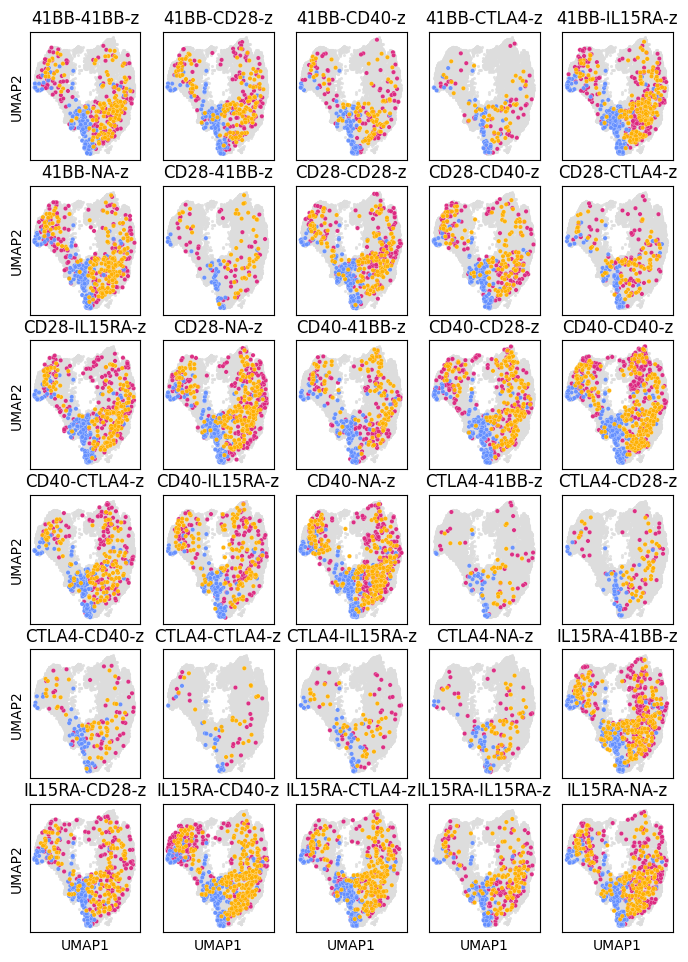

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32272/3183855490.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 21:03:28.510 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-23 21:03:28.809 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:28.817 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-23 21:03:28.817 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:28.817 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:28.817 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:28.848 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-08-23 21:03:30.872 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-23 21:03:31.476 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:31.485 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-23 21:03:31.485 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:31.485 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:31.485 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:31.522 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-23 21:03:32.200 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-23 21:03:32.769 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:32.777 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-23 21:03:32.777 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:32.782 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:32.782 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:32.817 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-08-23 21:03:33.447 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-23 21:03:33.990 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:33.997 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-23 21:03:33.997 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:33.998 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:33.998 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:34.024 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2025-08-23 21:03:34.629 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-23 21:03:35.150 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:35.156 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-23 21:03:35.157 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:35.157 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:35.157 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:35.186 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-23 21:03:36.002 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-23 21:03:36.536 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:36.544 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-23 21:03:36.545 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:36.545 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:36.545 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:36.576 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-08-23 21:03:37.223 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-23 21:03:37.720 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:37.728 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-23 21:03:37.729 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:37.729 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:37.729 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:37.757 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(43, 5120)
CD28-CD28-z


2025-08-23 21:03:38.368 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-23 21:03:38.885 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:38.893 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-23 21:03:38.893 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:38.893 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:38.893 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:38.920 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-23 21:03:39.552 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-23 21:03:40.086 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:40.094 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-23 21:03:40.094 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:40.095 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:40.095 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:40.131 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-08-23 21:03:40.774 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-23 21:03:41.300 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:41.311 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-23 21:03:41.311 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:41.311 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:41.311 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:41.342 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2025-08-23 21:03:41.931 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-23 21:03:42.414 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:42.421 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-23 21:03:42.422 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:42.422 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:42.422 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:42.449 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-23 21:03:43.162 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-23 21:03:43.696 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:43.704 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-23 21:03:43.704 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:43.705 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:43.705 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:43.735 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-08-23 21:03:44.359 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-23 21:03:44.903 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:44.912 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-23 21:03:44.912 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:44.912 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:44.913 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:44.954 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(139, 5120)
CD40-CD28-z


2025-08-23 21:03:45.595 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-23 21:03:46.166 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:46.175 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-23 21:03:46.176 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:46.177 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:46.178 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:46.203 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(147, 5120)
CD40-CD40-z


2025-08-23 21:03:46.880 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-23 21:03:47.371 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:47.385 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-23 21:03:47.385 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:47.386 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:47.386 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:47.431 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-23 21:03:48.350 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-23 21:03:48.817 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:48.826 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-23 21:03:48.826 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:48.826 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:48.826 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:48.860 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-23 21:03:52.169 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-23 21:03:52.399 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:52.405 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-23 21:03:52.405 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:52.405 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:52.406 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:52.430 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-23 21:03:52.899 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-23 21:03:53.120 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:53.128 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-23 21:03:53.129 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:53.129 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:53.130 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:53.164 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-08-23 21:03:53.639 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-23 21:03:53.877 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:53.883 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-23 21:03:53.883 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:53.883 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:53.884 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:53.910 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2025-08-23 21:03:54.370 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-23 21:03:54.619 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:54.626 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-23 21:03:54.626 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:54.626 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:54.626 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:54.651 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2025-08-23 21:03:55.112 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-23 21:03:55.340 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:55.345 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-23 21:03:55.345 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:55.345 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:55.345 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:55.369 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2025-08-23 21:03:55.780 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-23 21:03:56.010 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:56.016 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-23 21:03:56.016 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:56.016 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:56.016 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:56.042 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2025-08-23 21:03:56.573 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-23 21:03:56.853 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:56.858 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-23 21:03:56.858 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:56.858 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:56.859 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:56.885 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2025-08-23 21:03:57.469 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-23 21:03:57.745 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:57.750 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-23 21:03:57.751 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:57.751 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:57.751 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:57.775 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2025-08-23 21:03:58.354 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-23 21:03:58.629 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:58.635 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-23 21:03:58.635 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:58.635 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:58.635 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:58.659 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-23 21:03:59.423 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-23 21:03:59.759 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:03:59.766 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-23 21:03:59.769 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:03:59.769 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:03:59.769 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:03:59.822 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-23 21:04:00.522 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-23 21:04:00.873 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:04:00.879 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-23 21:04:00.879 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:04:00.880 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:04:00.880 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:04:00.906 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-08-23 21:04:01.636 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-23 21:04:02.167 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:04:02.176 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-23 21:04:02.177 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:04:02.177 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:04:02.177 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:04:02.210 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2025-08-23 21:04:02.930 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-23 21:04:03.540 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:04:03.546 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-23 21:04:03.546 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:04:03.547 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:04:03.547 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:04:03.578 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-23 21:04:04.232 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-23 21:04:04.715 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 21:04:04.722 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-23 21:04:04.722 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 21:04:04.722 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 21:04:04.723 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 21:04:04.750 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)


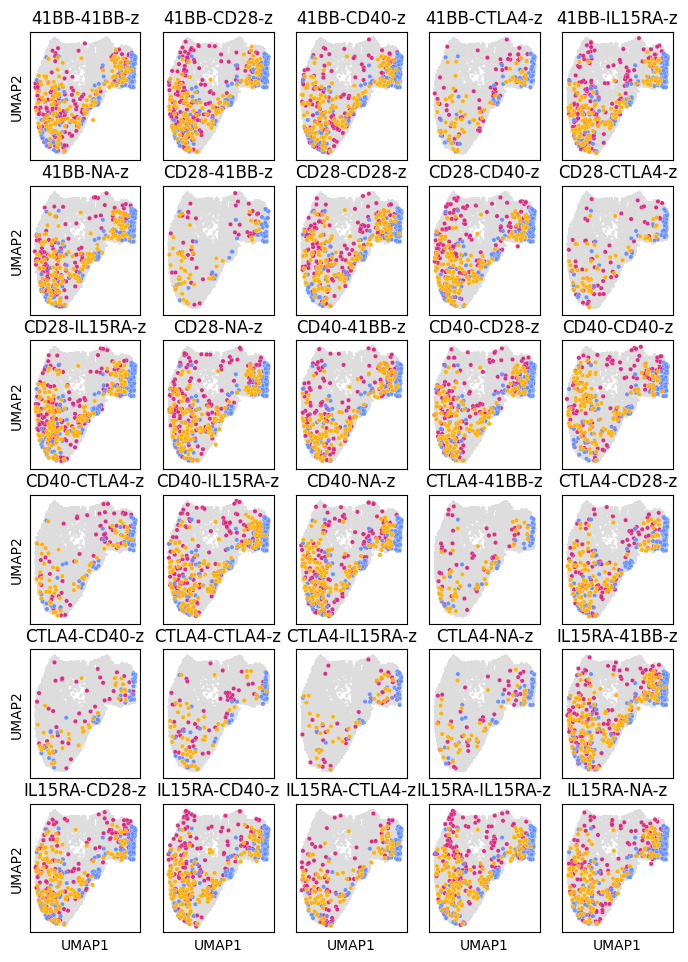

In [8]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
        config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
        flat_axes[i].get_legend().remove()
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        flat_axes[i].set_title(car)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
    plt.show()